# Tutorial on Intrinsic dimension estimation

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from duly import data
from duly.plot import plot_SLAn, plot_MDS, plot_matrix, get_dendrogram, plot_DecGraph


%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:

# import a test set
X = np.random.multivariate_normal([0, 0], [[1, 0.9999],[ 0.9999, 1]], size = (2000,))


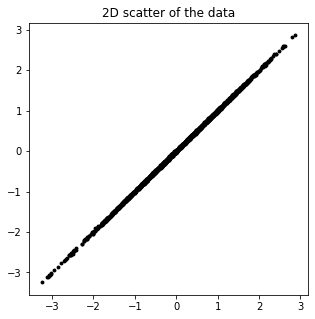

In [84]:
plt.figure(figsize = (5, 5))
plt.title('2D scatter of the data')
plt.scatter(X[:,0],X[:,1],s=15.,alpha=1.0,c='black',linewidths=0.0)
plt.show()

In [85]:
# initialise the Data class
_data = data.Data(X)


In [86]:
# estimate ID
_data.compute_distances()

Computation of the distances up to 1999 NNs started
Computation of the distances finished


In [87]:
# estimate ID
_data.compute_id_2NN()


ID estimation finished: selecting ID of 1.9849031423725632 +- 0.0


In [90]:
 ids_scaling, ids_scaling_std, r2s_scaling = _data.return_id_scaling_2NN(N_min = 10)

ID estimation finished: selecting ID of 1.9849031423725632 +- 0.0
ID estimation finished: selecting ID of 1.9490884398866979 +- 0.004385696707872245
ID estimation finished: selecting ID of 1.8468068346854023 +- 0.0722576112915057
ID estimation finished: selecting ID of 1.6768061106244783 +- 0.03342414025744283
ID estimation finished: selecting ID of 1.481619541391089 +- 0.03476750352820212
ID estimation finished: selecting ID of 1.2549716826346553 +- 0.0324195249634314
ID estimation finished: selecting ID of 1.2518068814589685 +- 0.03941741484494295
ID estimation finished: selecting ID of 1.227203442397837 +- 0.0301223774324084


<ErrorbarContainer object of 3 artists>

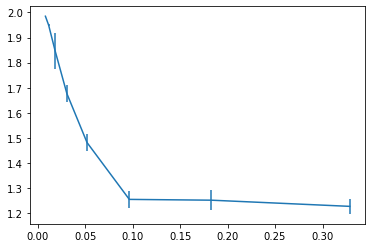

In [91]:
plt.errorbar(r2s_scaling, ids_scaling, ids_scaling_std)